## Lossy image autoencoders - with regularizer

Implemented with convolution and deconvolution networks in Tensorflow

- Samvram Sahu
- Arnab Karmakar

Referrence : Giuseppe Bonaccorso (https://www.bonaccorso.eu)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install numba
import multiprocessing
import tensorflow as tf
import os

from numba import jit
from keras.datasets import cifar10
from skimage.color import rgb2gray

from sklearn.decomposition import PCA

Using TensorFlow backend.


In [0]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [0]:
width = 32
height = 32
batch_size = 10
nb_epochs = 15
code_length = 128

In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [0]:
graph = tf.Graph()
beta = 0.01

with graph.as_default():
    # Global step
    global_step = tf.Variable(0, trainable=False)
    
    # Input batch
    input_images = tf.placeholder(tf.float32, shape=(batch_size, height, width, 3))

    # Convolutional layer 1
    conv1 = tf.layers.conv2d(inputs=input_images,
                             filters=32,
                             kernel_size=(3, 3),
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             activation=tf.nn.tanh)

    # Convolutional output (flattened)
    conv_output = tf.contrib.layers.flatten(conv1)

    # Code layer
    code_layer = tf.layers.dense(inputs=conv_output,
                                 units=code_length,
                                 activation=tf.nn.tanh)
    
    # Code output layer
    code_output = tf.layers.dense(inputs=code_layer,
                                  units=(height - 2) * (width - 2) * 3,
                                  activation=tf.nn.tanh)

    # Deconvolution input
    deconv_input = tf.reshape(code_output, (batch_size, height - 2, width - 2, 3))

    # Deconvolution layer 1
    deconv1 = tf.layers.conv2d_transpose(inputs=deconv_input,
                                         filters=3,
                                         kernel_size=(3, 3),
                                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                         activation=tf.sigmoid)
    
    # Output batch
    output_images = tf.cast(tf.reshape(deconv1, 
                                       (batch_size, height, width, 3)) * 255.0, tf.uint8)

    # Obtaining weights for use in regularization
    weights = tf.get_default_graph().get_tensor_by_name(os.path.split(code_layer.name)[0] + '/kernel:0')
    regularizer = tf.nn.l2_loss(weights)
    
    # Reconstruction L2 loss & L2 reguarization
    loss = tf.nn.l2_loss(input_images - deconv1) + beta*regularizer
    
    # Training operations
    learning_rate = tf.train.exponential_decay(learning_rate=0.0005, 
                                               global_step=global_step, 
                                               decay_steps=int(X_train.shape[0] / (2 * batch_size)), 
                                               decay_rate=0.95, 
                                               staircase=True)
    
    trainer = tf.train.RMSPropOptimizer(learning_rate)
    training_step = trainer.minimize(loss)

In [0]:
use_gpu = True

config = tf.ConfigProto(intra_op_parallelism_threads=multiprocessing.cpu_count(), 
                        inter_op_parallelism_threads=multiprocessing.cpu_count(), 
                        allow_soft_placement=True, 
                        device_count = {'CPU' : 1, 
                                        'GPU' : 1 if use_gpu else 0})

session = tf.InteractiveSession(graph=graph, config=config)

In [0]:
tf.global_variables_initializer().run()

In [0]:
@jit
def create_batch(t, gray=False):
    X = np.zeros((batch_size, height, width, 3 if not gray else 1), dtype=np.float32)
        
    for k, image in enumerate(X_train[t:t+batch_size]):
        if gray:
            X[k, :, :, :] = rgb2gray(image)
        else:
            X[k, :, :, :] = image / 255.0
        
    return X

In [10]:
for e in range(nb_epochs):
    total_loss = 0.0
    
    for t in range(0, X_train.shape[0], batch_size):
        feed_dict = {
            input_images: create_batch(t)
        }

        _, v_loss = session.run([training_step, loss], feed_dict=feed_dict)
        total_loss += v_loss
        
    print('Epoch {} - Total loss: {}'.format(e+1, total_loss))

Epoch 1 - Total loss: 994597.720161438
Epoch 2 - Total loss: 663629.241355896
Epoch 3 - Total loss: 643166.6488647461
Epoch 4 - Total loss: 641420.2884216309
Epoch 5 - Total loss: 634408.3393974304
Epoch 6 - Total loss: 631967.569026947
Epoch 7 - Total loss: 633064.5340766907
Epoch 8 - Total loss: 625672.9688415527
Epoch 9 - Total loss: 625063.3037910461
Epoch 10 - Total loss: 623656.9119911194
Epoch 11 - Total loss: 622690.6504402161
Epoch 12 - Total loss: 625422.911190033
Epoch 13 - Total loss: 620925.053691864
Epoch 14 - Total loss: 622165.4810752869
Epoch 15 - Total loss: 622873.358921051


### Show some reconstructions

In [0]:
feed_dict = {
    input_images: create_batch(0)
}


oimages = session.run([output_images], feed_dict=feed_dict)

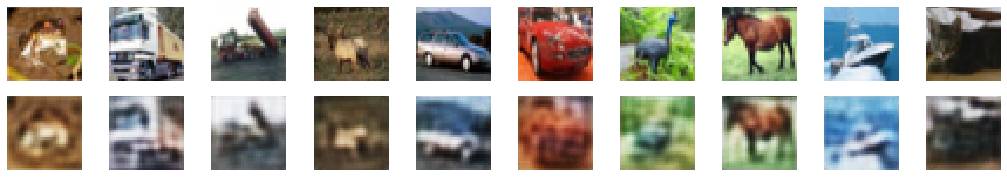

In [12]:
fig, ax = plt.subplots(2, batch_size, figsize=(18, 3))

for y in range(batch_size):
    ax[0, y].get_xaxis().set_visible(False)
    ax[0, y].get_yaxis().set_visible(False)
    ax[1, y].get_xaxis().set_visible(False)
    ax[1, y].get_yaxis().set_visible(False)

    ax[0, y].imshow(X_train[y])
    ax[1, y].imshow(oimages[0][y])